Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


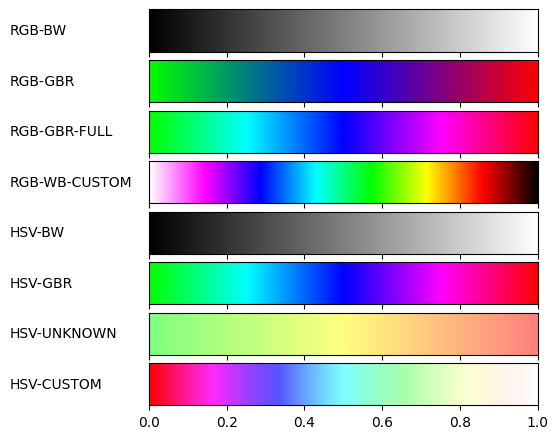

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from matplotlib import colors
import colorsys

#konwerter: nie trzeba implementować samemu, można wykorzystać funkcję z bilbioteki
def hsv2rgb(h, s, v):
    r, g, b = colorsys.hsv_to_rgb(h, s, v)
    return (r, g, b)

# poniżej znajdują się funkcje modelujące kolejne gradienty z zadania.
# v to pozycja na osi ox: v jest od 0 do 1. Zewnetrzna funkcja wywołuje te metody podając
# różne v i oczekując trójki RGB bądź HSV reprezentującej kolor. Np. (0,0,0) w RGB to kolor czarny. 
# Należy uwikłać v w funkcję modelującą kolor. W tym celu dla kolejnych gradientów trzeba przyjąć 
# sobie jakieś punkty charakterystyczne,
# np. widzimy, że po lewej stronie (dla v = 0) powinien być kolor zielony a w środku niebieski (dla v = 0.5),
# a wszystkie punkty pomiędzy należy interpolować liniowo (proporcjonalnie). 

def gradient_rgb_bw(v):
    return (v, v, v)


def gradient_rgb_gbr(v):
    if v < 0.5:
        return (0, 1 - 2 * v, 2 * v)
    else:
        return (2 * (v - 0.5), 0, 1 - 2 * (v - 0.5))


def gradient_rgb_gbr_full(v):    
    if v < 1/4:
        return (0, 1, 4*v)
    elif v < 1/2 and v >= 1/4:
        return (0, 1-4*(v-1/4), 1)
    elif v < 3/4 and v >= 1/2:
        return (4*(v-1/2), 0, 1)
    else:
        return (1, 0, 1-4*(v-3/4))


def gradient_rgb_wb_custom(v):
    if v < 1/7:
        return (1, 1-7*(v), 1)
    elif v >= 1/7 and v < 2/7:
        return (1-7*(v-1/7), 0, 1)
    elif v >= 2/7 and v < 3/7:
        return (0, 7*(v-2/7), 1)
    elif v >= 3/7 and v < 4/7:
        return (0, 1, 1-7*(v-3/7))
    elif v >= 4/7 and v < 5/7:
        return (7*(v-4/7), 1, 0)
    elif v >= 5/7 and v < 6/7:
        return (1, 1-7*(v-5/7), 0)
    else:
        return (1-7*(v-6/7), 0, 0)


def gradient_hsv_bw(v):
    return hsv2rgb(0, 0, v)


def gradient_hsv_gbr(v):
    return hsv2rgb((120+(v)*240)/360, 1, 1)


def gradient_hsv_unknown(v):
    return hsv2rgb((120-(v)*120)/360, 0.5, 1)


def gradient_hsv_custom(v):
    return hsv2rgb(1-v, 1-v, 1)
    #return hsv2rgb(v, 1-v, 1)


def plot_color_gradients(gradients, names):
    # For pretty latex fonts (commented out, because it does not work on some machines)
    #rc('text', usetex=True) 
    #rc('font', family='serif', serif=['Times'], size=10)
    rc('legend', fontsize=10)

    column_width_pt = 400         # Show in latex using \the\linewidth
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch

    fig, axes = plt.subplots(nrows=len(gradients), sharex=True, figsize=(size, 0.75 * size))
    fig.subplots_adjust(top=1.00, bottom=0.05, left=0.25, right=0.95)


    for ax, gradient, name in zip(axes, gradients, names):
        # Create image with two lines and draw gradient on it
        img = np.zeros((2, 1024, 3))
        for i, v in enumerate(np.linspace(0, 1, 1024)):
            img[:, i] = gradient(v)

        im = ax.imshow(img, aspect='auto')
        im.set_extent([0, 1, 0, 1])
        ax.yaxis.set_visible(False)

        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.25
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='left', fontsize=10)

    fig.savefig('my-gradients.pdf')
    
    
def toname(g):
    return g.__name__.replace('gradient_', '').replace('_', '-').upper()
    
gradients = (gradient_rgb_bw, gradient_rgb_gbr, gradient_rgb_gbr_full, gradient_rgb_wb_custom,
                 gradient_hsv_bw, gradient_hsv_gbr, gradient_hsv_unknown, gradient_hsv_custom)

plot_color_gradients(gradients, [toname(g) for g in gradients])

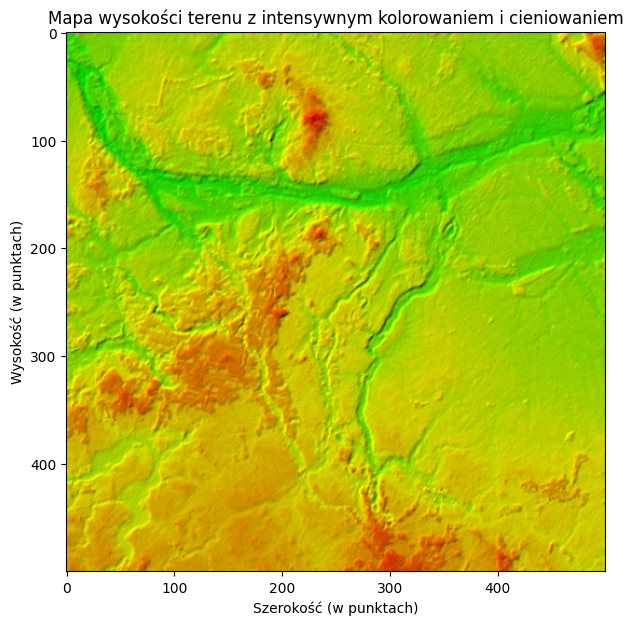

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb, rgb_to_hsv

# Tworzenie niestandardowego gradientu koloru: Zielony -> Żółty -> Czerwony
colors = [(0, (0, 1, 0)), (0.5, (1, 1, 0)), (1, (1, 0, 0))]
custom_cmap = LinearSegmentedColormap.from_list("CustomGradient", colors)

# Wczytaj dane z pliku DEM
file_path = 'big.dem.txt'  # Zastąp własną ścieżką do pliku
with open(file_path, 'r') as file:
    # Pierwsza linia pliku zawiera szerokość, wysokość i odległość
    w, h, distance = map(float, file.readline().strip().split())
    w, h = int(w), int(h)  # Przekształcenie szerokości i wysokości na int
    # Wczytaj wartości wysokości jako tablicę 2D
    height_map = np.array([list(map(float, file.readline().strip().split())) for _ in range(h)])

# Definiowanie wektora światła
light_vector = np.array([-1, -1, 1])
light_vector = light_vector / np.linalg.norm(light_vector) # dzielimy przez długość wektora = pierwiastek z sumy kwadratów

# Obliczanie gradientów wysokości w kierunkach x i y
dx, dy = np.gradient(height_map)

# Tworzenie wektorów normalnych dla każdego punktu
normals = np.dstack((dx, dy, np.ones_like(height_map) * distance/100 ))
normals /= np.linalg.norm(normals, axis=2, keepdims=True)  # Normalizacja normalnych
# Obliczenie współczynnika cienia (cosinus kąta między światłem a normalnymi)
cos_angle = np.sum((normals * light_vector), axis=2)  # Obcięcie do zakresu [0, 1]
angle_in_radians = np.arccos(cos_angle)
angle_in_degrees = np.degrees(angle_in_radians)
shade_factor = ((angle_in_degrees - angle_in_degrees.min()) / (angle_in_degrees.max() - angle_in_degrees.min())) ** 0.6

# Stosowanie niestandardowego gradientu do mapy wysokości
colored_height_map = custom_cmap((height_map - height_map.min()) / (height_map.max() - height_map.min()))

# Konwersja RGB do HSV w celu manipulacji kolorami
hsv_map = rgb_to_hsv(colored_height_map[:, :, :3])

# Zwiększenie saturacji i zastosowanie współczynnika cienia do jasności
hsv_map[:, :, 1] *= np.clip(hsv_map[:, :, 1] ** 2, 0, 1)  # Zwiększenie saturacji
hsv_map[:, :, 2] *= np.clip(shade_factor * 1.25, 0, 1)  # Zastosowanie cienia i zwiększenie jasności

# Konwersja mapy z powrotem do RGB po zmianach w HSV
shaded_map = hsv_to_rgb(hsv_map)

# Wyświetlanie wyniku
plt.figure(figsize=(7, 7))
plt.imshow(shaded_map)
plt.title("Mapa wysokości terenu z intensywnym kolorowaniem i cieniowaniem")
plt.xlabel("Szerokość (w punktach)")
plt.ylabel("Wysokość (w punktach)")
plt.show()
